In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as C
import scipy.integrate as integrate
from scipy.integrate import simpson, dblquad
from event_rate import dif_event_rate, integrand_jax, integrand_jax_m31, double_integral_2d
from tqdm import tqdm
import time
import os
import jax
import jax.numpy as jnp
from jax import vmap
from jax.scipy.integrate import trapezoid

os.environ["JAX_PLATFORM_NAME"] = "gpu"
print("Plataforma por defecto:", jax.default_backend())
print("Dispositivos disponibles:", jax.devices())
jax.config.update("jax_enable_x64", True)

Plataforma por defecto: gpu
Dispositivos disponibles: [CudaDevice(id=0)]


In [2]:
def integrand_jax(umin, x, D, rs, rho_c, t, m, l_coord, b_coord, uT):
    R0 = 2.622825944267662e+20
    # Convertir grados a radianes
    b = b_coord * jnp.pi / 180
    l = l_coord * jnp.pi / 180

    # r(x)
    r = jnp.sqrt((x * D)**2 + R0**2 - 2 * R0 * D * x * jnp.cos(b) * jnp.cos(l))
    
    # rho_NFW
    # c = r / rs
    c = jnp.maximum(r / rs, 1e-15)
    rho = rho_c / (c * (1 + c)**2)

    # rE(x)
    G = 6.67430e-11  # SI
    c_light = 299792458.0  # m/s
    k = 4 * G / c_light**2  # SI units
    rE = jnp.sqrt(k * m * D * x * (1 - x))  # en m

    factor = -c / (1 + c) + jnp.log(1 + c)
    Ml = 4 * jnp.pi * factor * rho_c * rs**3
    # vc = jnp.sqrt(G * Ml / (r))  # pasar r de kpc a m para SI
    vc = jnp.sqrt(G * Ml / jnp.maximum(r, 1e-15))

    
    # integrando
    # u_factor = jnp.sqrt(uT**2 - umin**2)
    u_diff_sq = uT**2 - umin**2
    u_factor = jnp.sqrt(jnp.maximum(u_diff_sq, 0.0))

    # vr = 2 * rE * u_factor / t  # t en horas
    vr = 2 * rE * u_factor / jnp.maximum(t, 1e-15)

    Q = (vr / vc)**2
    exp_fac = jnp.exp(-Q)
    f = 1.0
    integrando = 2 * D * (1 / u_factor) * rho * exp_fac * Q * vr**2 / m
    # print(rs)
    # print('u factor sin raiz', u_diff_sq)
    # print('Ml',Ml)
    # print('vc',vc)
    # print('rE', rE)
    
    # print('u_factor',u_factor)
    # print('vr',vr)
    # print('Q',Q)
    # print('exp_fac',exp_fac)
    # print(type(t))
    # print(2 * D*t**2  * rho * exp_fac * Q * vr**2 )
    return integrando*3600**2


the mass  1.5556761439304722e-06


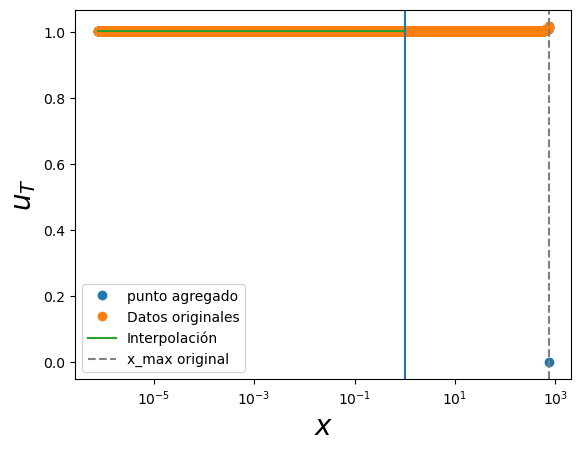

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os
i=56
# for i in range
string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
# Cargar datos
data = np.load('/home/anibal-pc/figures_final_makler/uT_curves/' + string)
arr0 = data['arr_0']
arr1 = data['arr_1']

ini = string.index('1e-')+3
fin = string.index('_NOT')
m = 10**float(string[ini:fin])
print('the mass ', m)

# Asegurar orden creciente
sorted_indices = np.argsort(arr1)
arr1 = arr1[sorted_indices]
arr0 = arr0[sorted_indices]

# Agregar un punto artificial que decae a 0
x_max = arr1[-1]
delta = 0.001 * x_max  # un pequeño paso más allá
arr1_extended = np.append(arr1, x_max + delta)
arr0_extended = np.append(arr0, 0.0)

# Interpolador cúbico o lineal (según prefieras)
interp_func = interp1d(arr1_extended, arr0_extended, kind='cubic', bounds_error=False, fill_value=0.0)

# Interpolación
if x_max + delta>1:
    limlogmax = 0
else:
    limlogmax = np.log10(x_max + delta)
x_interp = np.logspace(np.log10(arr1[0]), limlogmax , 1000)
y_interp = interp_func(x_interp)

# Plot
plt.plot(arr1_extended, arr0_extended, 'o', label='punto agregado')
plt.plot(arr1, arr0, 'o', label='Datos originales')
plt.plot(x_interp, y_interp, '-', label='Interpolación')

plt.axvline(x_max, color='gray', linestyle='--', label='x_max original')
plt.axvline(1)
# plt.xlabel("x",fontsize=20)
plt.xlabel(r"$x$",fontsize=20)
plt.ylabel(r"$u_T$",fontsize=20)
plt.xscale('log')
plt.legend()
plt.show()



In [4]:
def integrate_umin(integrand_ut, x,uT):
    umin = jnp.linspace(0,uT-1e-15,1000)
    if x<1:
        y_vals = integrand_ut(umin,x,uT)    
        # plt.plot(umin, y_vals)
        return trapezoid(y_vals, umin, dx=1e-20)



def integrate_dl(x, integrandx):

    result = trapezoid(integrandx, x, dx = 1e-20)
    return result

def integrate_umin_dl(f, X, UT):
    integrand_x = []

    for i in range(len(X[X<1])):
        x, uT = X[i], UT[i]
        integrand_x.append(integrate_umin(f, x, uT))

    integrandx = np.array([float(integrand_x[f]) for f in range(len(integrand_x)-1)])
    x = X[X<1][0:-1]
        
    return integrate_dl(x,integrandx)


In [8]:
from tqdm import tqdm
dgama_dt = []

def Dgama_Dt(m, x_interp, y_interp):
    t_hat = np.logspace(-2, 1, 100)*u.hour.to('s')
    for t_val in tqdm(t_hat):
        rho_c_MW = 4.88e6*C.M_sun/u.kpc**3
        rs_MW = 21.5*u.kpc
        rho_c_M31 = 4.96e6*C.M_sun/u.kpc**3
        rs_M31 = 25*u.kpc
        uT = 1.5
        l,b = 121.2, -21.6 
        D = 770*u.kpc
        rs_MW_val = rs_MW.to('m').value
        rho_c_MW_val = rho_c_MW.to('kg/m^3').value
        
        rs_M31_val = rs_M31.to('m').value
        rho_c_M31_val = rho_c_M31.to('kg/m^3').value
        
        D_val = D.to('m').value
        
        l_val = l
        b_val = b
        
        # m_val = m.to('kg').value
        M_sun = 1.988409870698051e+30
        m_val = m*M_sun
        
        f_jax_MW = lambda umin, x, uT_val: integrand_jax(umin, x, D=D_val, rs=rs_MW_val, rho_c=rho_c_MW_val,
                                           t=t_val, m=m_val, l_coord=l,
                                           b_coord=b, uT=uT_val)
    
        f_jax_M31 = lambda umin, x, uT_val: integrand_jax_m31(umin, x, D=D_val, rs=rs_M31_val, rho_c=rho_c_M31_val,
                                       t=t_val, m=m_val, l_coord=l,
                                       b_coord=b, uT=uT_val)
        
        
        dgama_dt.append(integrate_umin_dl(f_jax_MW, x_interp, y_interp) + integrate_umin_dl(f_jax_M31, x_interp, y_interp))
    return t_hat/3600 , np.array(dgama_dt)


    # trapezoid(np.array([float(integrand_x[f]) for f in range(len(integrand_x)-1)]),x_interp[x_interp<1][0:-1], dx=1e-15)

In [ ]:
t_hat , dgama_dt = Dgama_Dt(m, x_interp, y_interp)

 61%|█████████████████████████▌                | 61/100 [02:30<01:35,  2.45s/it]

(1e-08, 0.01)

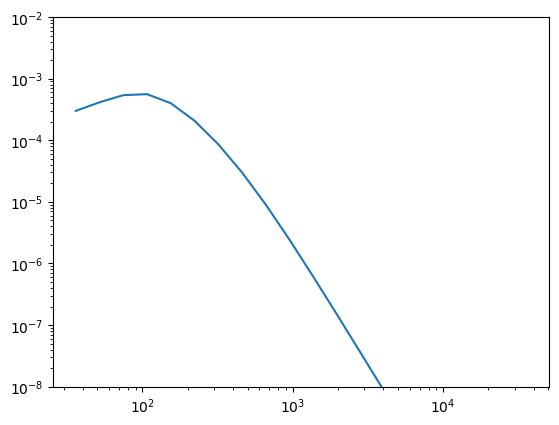

In [7]:
# plt.plot(t_hat, dgama_dt)
plt.loglog(t_hat , dgama_dt)

plt.ylim(10**(-8),10**(-2))

In [19]:
# m_val = m* u.M_sun.to('kg')
# m_val

In [86]:
len(np.array(dgama_dt))

100